# PIA PDI V6 EQUIPO 2
### Importar Librerías

In [22]:
import numpy as np
import os
import tensorflow as tf
import tensorflow.io as tfio
import matplotlib.pyplot as plt
import pandas as pd

### Función para obtener una foto de la cámara

In [2]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      

      video.srcObject = stream;
      await video.play();
      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      //Display the red square
      var minDim = Math.min(video.videoWidth, video.videoHeight);

      const redBox = document.createElement('canvas');
      redBox.width = video.videoWidth;
      redBox.height = video.videoHeight;
      redBox.style.position = 'relative';
      redBox.style.top = `-${video.videoHeight}px`;
      ctx = redBox.getContext('2d');
      ctx.rect((video.videoWidth - minDim) / 2,
               (video.videoHeight - minDim) / 2, 
               minDim, minDim);
      ctx.lineWidth = "6";
      ctx.strokeStyle = "red";
      ctx.stroke();

      div.appendChild(redBox);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

### Función de preprocesado

In [3]:
def preprocess(imagePath):
    image = tfio.read_file(imagePath)
    image = tfio.decode_image(image)

    minDim = min(image.shape[:2])
    image = tf.keras.layers.CenterCrop(minDim, minDim)(image)
    image = tf.image.resize(image, [200,200])
    image = tf.cast(image, tf.float32) / 255.0
    
    return image

### Función de obtención de la predicción

In [20]:
def predict(model, imagePath):
    labelsnp = np.array(['A', 'E', 'I', 'O', 'U', 'Nada'])

    image = preprocess(imagePath)
    prediction = model.predict(tf.expand_dims(image, axis=0))
    prediction = prediction * 100

    display(Image(tfio.encode_png(
        tf.cast(image*255, tf.uint8)).numpy()))

    predictionDf = pd.DataFrame(prediction, columns=labelsnp)
    display(predictionDf.style
            .hide(axis='index')
            .format(precision=2))

    #print(prediction)
    print(f"Predicción: '{labelsnp[np.argmax(prediction)]}'\n")
    #return prediction

### Importar el modelo

In [5]:
#model=tf.keras.models.load_model('pdi15EsigF.h5')
model=tf.keras.models.load_model('pdi20EsigF.h5')

### Pruebas con la cámara

<IPython.core.display.Javascript object>

Saved to photo.jpg
1/1 [==============================] - 0s 41ms/step


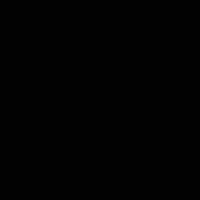

A,E,I,O,U,Nada
0.00,0.00,0.00,0.00,0.00,100.00


Predicción: 'Nada'



In [21]:
try:
    filename = take_photo()
    print('Saved to {}'.format(filename))
    predict(model, filename)
  
    # Show the image which was just taken.
    #display(Image(filename))
except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))